In [17]:
from data_analysis.data_tools.time_series import TimeSeries
from data_analysis.data_tools.influx_client import InfluxClient
import matplotlib.pyplot as plt

import numpy as np
client = InfluxClient()

start = "2024-07-16T15:00:00Z"
stop = "2024-07-17T03:00:00Z"

In [18]:
motor_current: TimeSeries = client.query_time_series(start, stop, "BatteryCurrent", units="A")
motor_current_direction: TimeSeries = client.query_time_series(start, stop, "BatteryCurrentDirection", units="")
vehicle_velocity: TimeSeries = client.query_time_series(start, stop, "VehicleVelocity", units="m/s")
motor_voltage = client.query_time_series(start, stop, "BatteryVoltage", units="V")

motor_current, motor_current_direction, vehicle_velocity, motor_voltage = TimeSeries.align(motor_current, motor_current_direction, vehicle_velocity, motor_voltage)

/Users/joshuariefman/Simulation/data_analysis/data_tools/time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "car": query_df["car"][0],
/Users/joshuariefman/Simulation/data_analysis/data_tools/time_series.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "measurement": query_df["_measurement"][0],
/Users/joshuariefman/Simulation/data_analysis/data_tools/time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

In [20]:
motor_current_signed = motor_current.promote(np.fromiter(map(lambda x: -x[1] if motor_current_direction[x[0]] == 1 else x[1], enumerate(motor_current)), dtype=float))

In [30]:
import csv
from datetime import datetime

lap_data = []

with open("data_analysis/data/lap_times.csv", newline='') as csv_file:
    race_begin = datetime.strptime("10:00:00", "%H:%M:%S").time()
    get_seconds = lambda x: x.hour * 3600 + x.minute * 60 + x.second
    race_begin_s = get_seconds(race_begin)

    reader = csv.reader(csv_file, delimiter=' ')
    for row in reader:
        split_row = row[0].split(',')

        lap_end_time_dt = datetime.strptime(split_row[2], "%H:%M:%S").time()
        lap_elapsed_time_dt = datetime.strptime(split_row[3], "%H:%M:%S").time()

        lap_end_time = get_seconds(lap_end_time_dt) - race_begin_s
        lap_elapsed_time = get_seconds(lap_elapsed_time_dt)

        lap_begin_time = lap_end_time - lap_elapsed_time
        lap_data.append([lap_begin_time, lap_end_time])

[[0, 424],
 [424, 789],
 [789, 1219],
 [1219, 1641],
 [1641, 2039],
 [2039, 2421],
 [2421, 2865],
 [2865, 3250],
 [3250, 3639],
 [3639, 4025],
 [4025, 4397],
 [4397, 4837],
 [4837, 5311],
 [5311, 5785],
 [5785, 6248],
 [6248, 6699],
 [6699, 7152],
 [7152, 7569],
 [7569, 7993],
 [7993, 8433],
 [8433, 8857],
 [8857, 9283],
 [9283, 9706],
 [9706, 10117],
 [10117, 10525],
 [10525, 10939],
 [10939, 11353],
 [11353, 11773],
 [11988, 12418],
 [12418, 12824],
 [12824, 13237],
 [13237, 13656],
 [14196, 14654],
 [14654, 15112],
 [15112, 15526],
 [15526, 15924],
 [15924, 16314],
 [16314, 16681],
 [16681, 17073],
 [17073, 17458],
 [17458, 17851],
 [17851, 18278],
 [18278, 18788],
 [18788, 19289],
 [19289, 19793],
 [19793, 20380]]

In [37]:
motor_energy = motor_current.promote(motor_current_signed * motor_voltage * motor_current_signed.granularity)

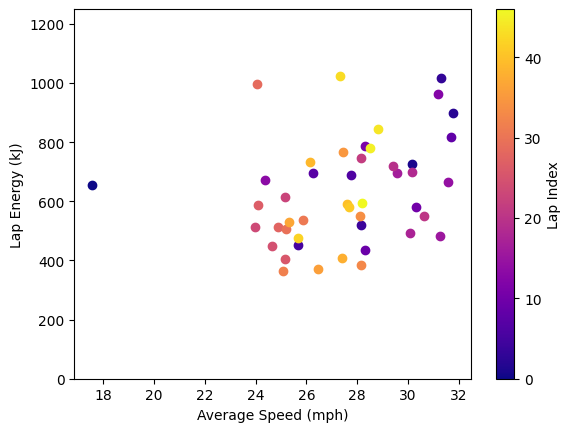

In [81]:
fig, ax = plt.subplots()

sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=0, vmax=len(lap_data)-1))
colors = plt.cm.plasma(np.linspace(0, 1, len(lap_data)))

# Create a scatter plot
sc = ax.scatter([], [], c=[], cmap='plasma')  # Initialize the scatter plot with empty data
average_speeds = [np.mean(vehicle_velocity[time_range]) * 3.6 / 1.609 for time_range in lap_data]
lap_energies = [np.sum(motor_energy[time_range]) / 1e3 for time_range in lap_data]

for i, lap in enumerate(lap_data):
    time_range = slice(float(lap[0]), float(lap[1]))
    average_speed = np.mean(vehicle_velocity[time_range]) * 3.6 / 1.609
    lap_energy = np.sum(motor_energy[time_range]) / 1e3
    ax.scatter(average_speed, lap_energy, color=colors[i])

ax.set_xlabel("Average Speed (mph)")
ax.set_ylabel("Lap Energy (kJ)")
ax.set_ylim([0, 1250])
# ax.set_xlim([0, max(average_speeds)])

# Create colorbar
norm = plt.Normalize(0, len(lap_data))
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='plasma'), ax=ax)
cbar.set_label('Lap Index')  # Label for the colorbar

plt.show()

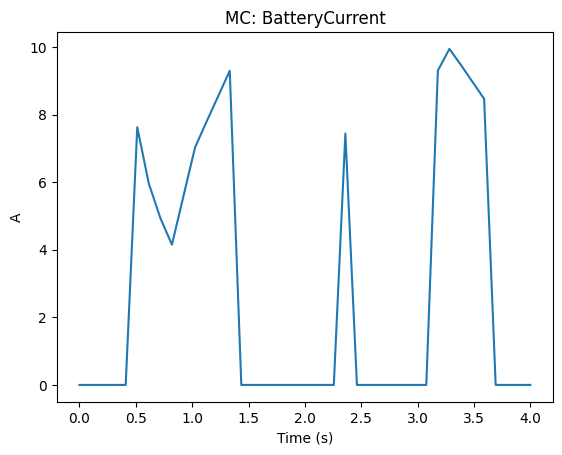

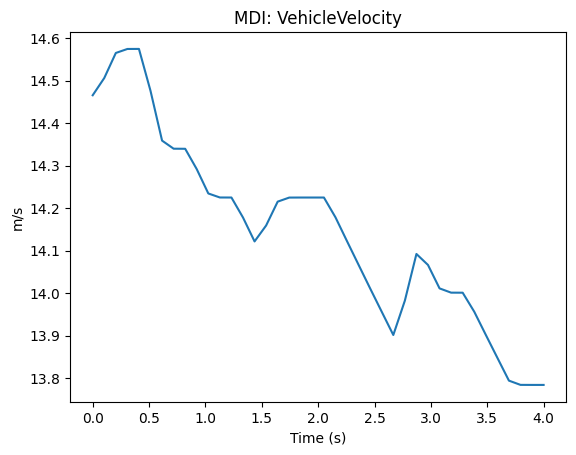

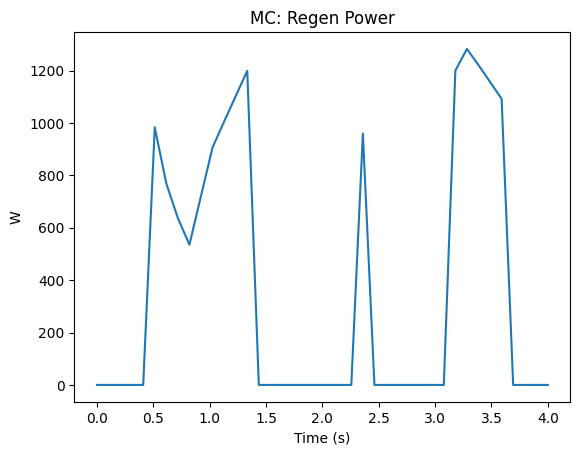

Energy: 1515.410723071695
Delta KE: 3370.7372545534035
Regen Efficiency: 0.450%


In [70]:
regen_current = motor_current.promote(np.where(motor_current_signed < 0, -motor_current_signed, 0))
regen_power = motor_voltage * regen_current
regen_power.units = "W"
regen_power.meta["field"] = "Regen Power"

time_slice = slice(float(440 + 83), float(440 + 87))


initial_velocity = vehicle_velocity[float(440 + 83)]                                # Units: m/s
final_velocity = vehicle_velocity[float(440 + 87)]                                   # Units: m/s
kinetic_energy  = lambda vi, vf: 0.5 * 350 * (vf**2 - vi**2)                    # Units: J
delta_kinetic_energy = -kinetic_energy(final_velocity, initial_velocity)        # Units: J

regen_current[time_slice].plot()
vehicle_velocity[time_slice].plot()
regen_power[time_slice].plot()
print(f"Energy: {np.trapz(regen_power[time_slice], regen_power[time_slice].x_axis)}")
print(f"Delta KE: {-delta_kinetic_energy}")
print(f"Regen Efficiency: {np.trapz(regen_power[time_slice], regen_power[time_slice].x_axis) / -delta_kinetic_energy:.3f}%")

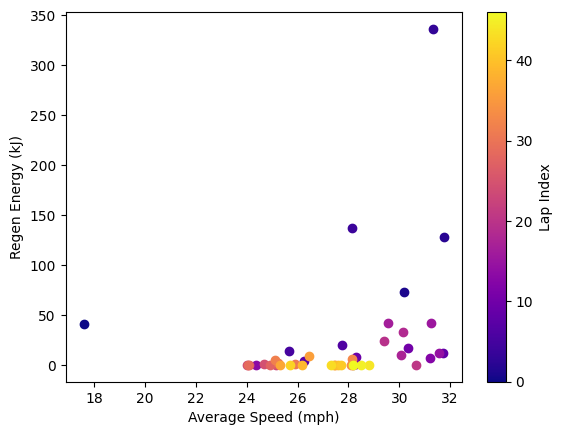

In [76]:
fig, ax = plt.subplots()

sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=0, vmax=len(lap_data)-1))
colors = plt.cm.plasma(np.linspace(0, 1, len(lap_data)))

# Create a scatter plot
sc = ax.scatter([], [], c=[], cmap='plasma')  # Initialize the scatter plot with empty data

for i, lap in enumerate(lap_data):
    time_range = slice(float(lap[0]), float(lap[1]))
    average_speed = np.mean(vehicle_velocity[time_range]) * 3.6 / 1.609
    lap_energy = np.sum(regen_power[time_range]) / 1e3
    ax.scatter(average_speed, lap_energy, color=colors[i])

ax.set_xlabel("Average Speed (mph)")
ax.set_ylabel("Regen Energy (kJ)")

# Create colorbar
norm = plt.Normalize(0, len(lap_data))
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='plasma'), ax=ax)
cbar.set_label('Lap Index')  # Label for the colorbar

plt.show()